# Deepfake Detector Colab (Optimized for 12GB RAM)
This notebook is optimized for Google Colab with 12GB RAM.

In [ ]:
# Install Kaggle API
!pip install kaggle

In [ ]:
# Upload Kaggle API key
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sreeharisj","key":"1059c3ff2ab0e4d77e2180333e98bdd9"}'}

In [ ]:
# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!unzip -q deepfake-and-real-images.zip -d /content/dataset/
!rm deepfake-and-real-images.zip

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 98% 1.66G/1.68G [00:15<00:00, 272MB/s]
100% 1.68G/1.68G [00:15<00:00, 115MB/s]


## Prepare Dataset Folders and Splits

In [ ]:
import os, shutil, random
import tensorflow as tf
from tensorflow.keras import layers, models

# Dataset paths
BASE_PATH = '/content/dataset/Dataset'
TARGET_BASE = '/content'
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
RANDOM_SEED = 123

# Define the actual class names
class_names = ['Fake', 'Real']
print('Using classes:', class_names)

# Create target folders with correct class subdirectories
for split in ['train_data', 'val_data', 'test_data']:
    for cls in class_names:
        os.makedirs(os.path.join(TARGET_BASE, split, cls), exist_ok=True)

# Process each of the original splits (Train, Validation, Test) from the downloaded dataset
original_splits = ['Train', 'Validation', 'Test']

for original_split in original_splits:
    original_split_path = os.path.join(BASE_PATH, original_split)
    if not os.path.isdir(original_split_path):
        print(f"Warning: Original split directory not found: {original_split_path}")
        continue

    for cls in class_names:
        cls_path = os.path.join(original_split_path, cls)
        if not os.path.isdir(cls_path):
             print(f"Warning: Class directory not found in original split: {cls_path}")
             continue

        images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.seed(RANDOM_SEED) # Reseed for each class/split to ensure consistent shuffling
        random.shuffle(images)

        n_total = len(images)
        n_val = int(VAL_SPLIT * n_total)
        n_test = int(TEST_SPLIT * n_total)
        n_train = n_total - n_val - n_test

        # Determine which target split directories to copy to based on the original split
        if original_split == 'Train':
             # Distribute images from original Train into our train, val, test splits
             for i, img in enumerate(images):
                 if i < n_train:
                     dst_split = 'train_data'
                 elif i < n_train + n_val:
                     dst_split = 'val_data'
                 else:
                     dst_split = 'test_data'
                 dst = os.path.join(TARGET_BASE, dst_split, cls, img)
                 shutil.copy(os.path.join(cls_path, img), dst)

        elif original_split == 'Validation':
             # Copy images from original Validation into our val split
             for img in images:
                  dst = os.path.join(TARGET_BASE, 'val_data', cls, img)
                  shutil.copy(os.path.join(cls_path, img), dst)

        elif original_split == 'Test':
             # Copy images from original Test into our test split
             for img in images:
                  dst = os.path.join(TARGET_BASE, 'test_data', cls, img)
                  shutil.copy(os.path.join(cls_path, img), dst)

print('Dataset split and copy done!')

Using classes: ['Fake', 'Real']
Dataset split and copy done!


## Dataset Streaming, Augmentation, and Prefetch

In [ ]:
BATCH_SIZE = 16  # smaller batch
IMG_SIZE = (160, 160)  # smaller images for memory
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

def create_dataset(dir_path, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        class_names=['Fake', 'Real'] # Explicitly provide the class names
    )
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = create_dataset('/content/train_data')
val_ds   = create_dataset('/content/val_data', shuffle=False)
test_ds  = create_dataset('/content/test_data', shuffle=False)

Found 98002 files belonging to 2 classes.
Found 54568 files belonging to 2 classes.
Found 30266 files belonging to 2 classes.


In [ ]:
# Inspect the downloaded dataset structure to find the actual class names
import os

# Assuming the dataset was extracted to /content/dataset/Dataset
dataset_root = '/content/dataset/Dataset'

# List directories in the root of the extracted dataset
extracted_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
print("Directories found in the extracted dataset root:", extracted_dirs)

# Assuming the class directories are within 'Train' or similar subdirectories, let's inspect one
if 'Train' in extracted_dirs:
    train_dataset_path = os.path.join(dataset_root, 'Train')
    train_subdirs = [d for d in os.listdir(train_dataset_path) if os.path.isdir(os.path.join(train_dataset_path, d))]
    print("Subdirectories found within the 'Train' directory:", train_subdirs)

Directories found in the extracted dataset root: ['Train', 'Test', 'Validation']
Subdirectories found within the 'Train' directory: ['Real', 'Fake']


## Model Definition (MobileNetV2)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

def make_model(img_size=IMG_SIZE, dropout=0.3):
    base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    base.trainable = False

    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = data_augmentation(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model, base

model, base_model = make_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training (Head and Fine-Tuning)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

BASE_LR = 1e-4
FINE_TUNE_LR = 1e-5
EPOCHS_HEAD = 5  # smaller for memory
EPOCHS_FINE = 5

# Redefine make_model here to ensure it's available
def make_model(img_size=(160, 160), dropout=0.3):
    base = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    base.trainable = False

    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    # Assuming data_augmentation is defined in a previous cell and is available
    x = data_augmentation(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model, base


# Ensure model and base_model are defined
model, base_model = make_model()

model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

history_head = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(FINE_TUNE_LR),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE)

Epoch 1/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 246s 37ms/step - AUC: 0.8029 - accuracy: 0.7265 - loss: 0.5335 - val_AUC: 0.8533 - val_accuracy: 0.7301 - val_loss: 0.5264
Epoch 2/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 225s 33ms/step - AUC: 0.8500 - accuracy: 0.7665 - loss: 0.4766 - val_AUC: 0.8600 - val_accuracy: 0.7404 - val_loss: 0.5114
Epoch 3/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 224s 36ms/step - AUC: 0.8589 - accuracy: 0.7740 - loss: 0.4628 - val_AUC: 0.8640 - val_accuracy: 0.7437 - val_loss: 0.5040
Epoch 4/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 202s 33ms/step - AUC: 0.8659 - accuracy: 0.7811 - loss: 0.4523 - val_AUC: 0.8679 - val_accuracy: 0.7465 - val_loss: 0.5022
Epoch 5/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 201s 33ms/step - AUC: 0.8691 - accuracy: 0.7825 - loss: 0.4469 - val_AUC: 0.8726 - val_accuracy: 0.7407 - val_loss: 0.5083
Epoch 1/5
6126/6126 ━━━━━━━━━━━━━━━━━━━━ 782s 117ms/step - AUC: 0.9305 - accuracy: 0.8528 - loss: 0.3227 - val_AUC: 0.9617 - val_accuracy: 0.8933 - val_loss: 0.2516
Epoch 2/5
6126/

## Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

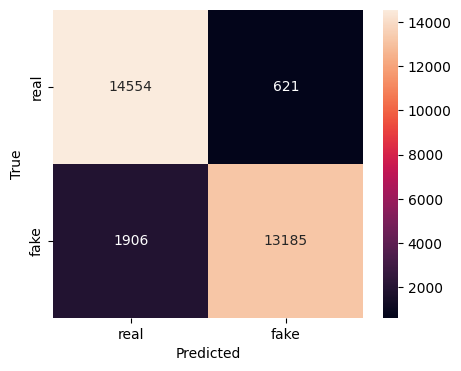

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred, y_scores = [], [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_scores.extend(preds.ravel().tolist())
    y_pred.extend((preds.ravel() > 0.5).astype(int).tolist())

print(classification_report(y_true, y_pred, target_names=['real','fake']))
print('ROC AUC:', roc_auc_score(y_true, y_scores))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

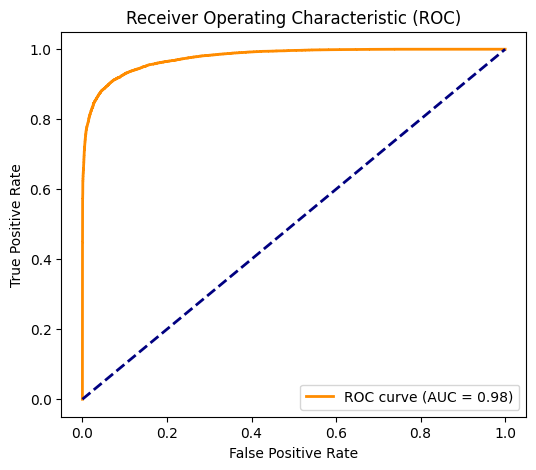

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np # Import numpy

# Redefine y_true and y_scores by iterating through the test_ds
y_true, y_pred, y_scores = [], [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().tolist())
    y_scores.extend(preds.ravel().tolist())
    y_pred.extend((preds.ravel() > 0.5).astype(int).tolist())


precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [4]:
import random
import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns # Import seaborn
import tensorflow as tf # Import tensorflow
import numpy as np # Import numpy

# Redefine test_ds by adding the code from cell 4e749621
BATCH_SIZE = 16  # smaller batch
IMG_SIZE = (160, 160)  # smaller images for memory
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

def create_dataset(dir_path, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        class_names=['Fake', 'Real'] # Explicitly provide the class names
    )
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# train_ds = create_dataset('/content/train_data') # Not needed in this cell
# val_ds   = create_dataset('/content/val_data', shuffle=False) # Not needed in this cell
test_ds  = create_dataset('/content/test_data', shuffle=False)


plt.figure(figsize=(10,10))
for i in range(9):
    # Get a random batch and then unbatch to get a single image and label
    random_batch = next(iter(test_ds.shuffle(buffer_size=1000).take(1)))
    img, label = random_batch[0][0], random_batch[1][0]

    pred = model.predict(tf.expand_dims(img, 0))[0][0]
    plt.subplot(3,3,i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {'real' if label==0 else 'fake'}\nPred: {'real' if pred<0.5 else 'fake'} ({pred:.2f})")
    plt.axis('off')
plt.show()

NameError: name 'test_ds' is not defined

<Figure size 1000x1000 with 0 Axes>